In [316]:
#All the web scraping libraries we can use
import requests
import requests_cache
import lxml.html as lx
from lxml import html
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
import time
import folium
import plotly.express as px
from folium import IFrame
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import FileLink

In [317]:
#All Data
#API URL
url = "https://api.eia.gov/v2/electricity/retail-sales/data/"

#My personal API Key (Noah Glosson's)
api_key = 'hpPWfbFW0MjGinc5M9CHCX64ks6ZXh2DWlmgFQIm'

#Headers
headers = {
    "X-API-Key": api_key
}

#Proper Parameters
params = {
    "frequency": "monthly",
    "data[0]": "sales",
    "facets[sectorid][]": "ALL",
    "facets[stateid][]": "CA",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

#Getting our data
response = requests.get(url, headers=headers, params=params)
california_data = response.json()



In [318]:
#Extracting what we want
month_list = [entry['period'] for entry in california_data['response']['data']]
month_data = month_list[::-1]
sales_list=[float(entry['sales']) for entry in california_data['response']['data']]
sales_data=sales_list[::-1]
# Assuming month_data and sales_data are already defined
california_df = pd.DataFrame({
    'date': pd.to_datetime(month_data, format='%Y-%m'),
    'sales': sales_data
})

# Filter the data to include only from 2020 to 2024
updated_california = california_df[(california_df['date'] >= '2020-01-01') & (california_df['date'] <= '2024-9-01')]


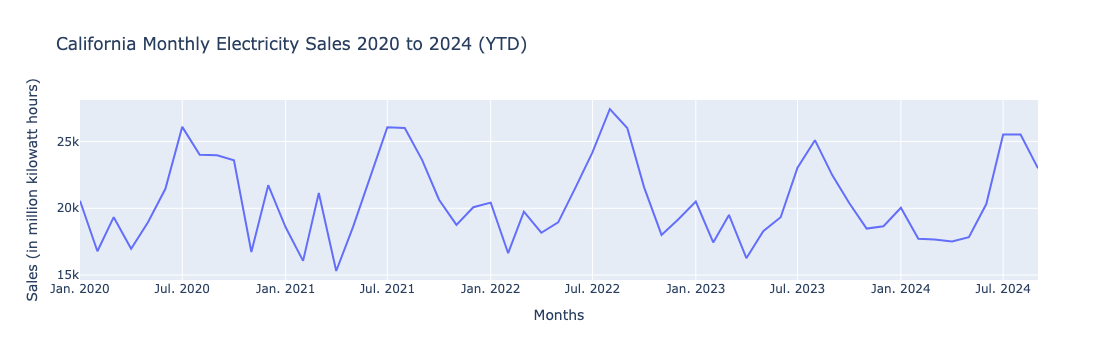

In [319]:
#Interactive Plot
fig = px.line(updated_california, x='date', y='sales', 
              title='California Monthly Electricity Sales 2020 to 2024 (YTD)', 
              labels={'date': 'Month', 'sales': 'Sales (in million kilowatt hours)'})

#Updating the labels
fig.update_layout(
    xaxis_tickformat='%b. %Y',  #Changing the format
    xaxis_title='Months',
    yaxis_title='Sales (in million kilowatt hours)'
)
fig.write_html('CA_Time_Series.html')
# Show the plot
fig.show()

In [320]:
fig.write_html('CA_Time_Series.html')
FileLink('CA_Time_Series.html')

/Users/NoahGlosson/Desktop/STA 141B Material/CA_Time_Series.html

In [291]:
driver = webdriver.Chrome()
#Big url
base_url="https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/4/tavg/1/0/2020-2024"
params = {
    "base_prd": "true",          
    "begbaseyear": "1901",       
    "endbaseyear": "2000"        
}

# Construct URL with parameters
url = f"{base_url}?base_prd={params['base_prd']}&begbaseyear={params['begbaseyear']}&endbaseyear={params['endbaseyear']}"
driver.get(url) #Get our web driver URL
time.sleep(5) 
soup = BeautifulSoup(driver.page_source, 'lxml')
table = soup.find('table')

#Dictionary to store results
temp_dict = {}

#If we discovered a table
if table:
    rows = table.find_all('tr')
    for row in rows:
        #Extract Rows
        cols = row.find_all('td')
        # If there are columns in the row (skip the header row)
        if len(cols) > 0:
            #Cleaning up our text
            cols = [col.text.strip() for col in cols]
            time_period = cols[0]
            temp_str = cols[1]
            #Removing Farenheit symbol and making temperatures floats
            temp_float = float(temp_str.replace('°F', '').strip()) 
            
            #Creating a dictionary
            temp_dict[time_period] = temp_float

california_temp_dictionary= dict(reversed(list(temp_dict.items()))) #Reversing the order
driver.quit()

In [292]:
#Updating our data values
california_temperatures=list(california_temp_dictionary.values())
len(california_temperatures)
#We want to get rid of final two months
values=california_temperatures[:-2]
updated_california['temperature']=values

/var/folders/ms/1jfxwvmn1r99486_p5c6snv00000gq/T/ipykernel_226/2450854602.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [293]:
driver = webdriver.Chrome()
url="https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/4/pcp/1/0/2020-2024"
params = {
    "base_prd": "true",          
    "begbaseyear": "1901",       
    "endbaseyear": "2000"        
}

# Construct URL with parameters
winter_url = f"{url}?base_prd={params['base_prd']}&begbaseyear={params['begbaseyear']}&endbaseyear={params['endbaseyear']}"
driver.get(winter_url) #Get our web driver URL
time.sleep(5) 
soup = BeautifulSoup(driver.page_source, 'lxml')
table = soup.find('table')

#Dictionary to store results
prec_dict = {}

#If we discovered a table
if table:
    rows = table.find_all('tr')
    for row in rows:
        #Extract Rows
        cols = row.find_all('td')
        # If there are columns in the row (skip the header row)
        if len(cols) > 0:
            #Cleaning up our text
            cols = [col.text.strip() for col in cols]
            time_period = cols[0]
            perc_str = cols[1]
            #Removing Farenheit symbol and making temperatures floats
            perc_float = float(perc_str.replace('"', '').strip()) 
            
            #Creating a dictionary
            prec_dict[time_period] = perc_float

perc_dictionary= dict(reversed(list(prec_dict.items()))) #Reversing the order

In [294]:
#Percipitation Data as well
prec_values=list(perc_dictionary.values())
# Create a scatter plot instead of a line plot
prec_values=prec_values[:-2]
updated_california['precipitation']=prec_values
CA_data=updated_california
CA_data = CA_data.reset_index(drop=True)
CA_data['date']=pd.to_datetime(CA_data['date'])
CA_data['month'] = CA_data['date'].dt.strftime('%b. %Y')
#Creating our new Data Frame
CA_data = CA_data[['month'] + [col for col in CA_data.columns if col != 'month' and col != 'date']]
CA_data

/var/folders/ms/1jfxwvmn1r99486_p5c6snv00000gq/T/ipykernel_226/3890880293.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,month,sales,temperature,precipitation
0,Jan. 2020,20562.24693,45.3,2.06
1,Feb. 2020,16783.77126,49.2,0.21
2,Mar. 2020,19334.99603,48.0,3.19
3,Apr. 2020,16963.48016,56.6,1.99
4,May. 2020,18956.69382,64.6,1.20
5,Jun. 2020,21459.87126,70.4,0.16
6,Jul. 2020,26098.31993,76.6,0.05
7,Aug. 2020,24001.90557,78.9,0.10
8,Sep. 2020,23975.36364,74.0,0.04
9,Oct. 2020,23587.97568,66.2,0.05


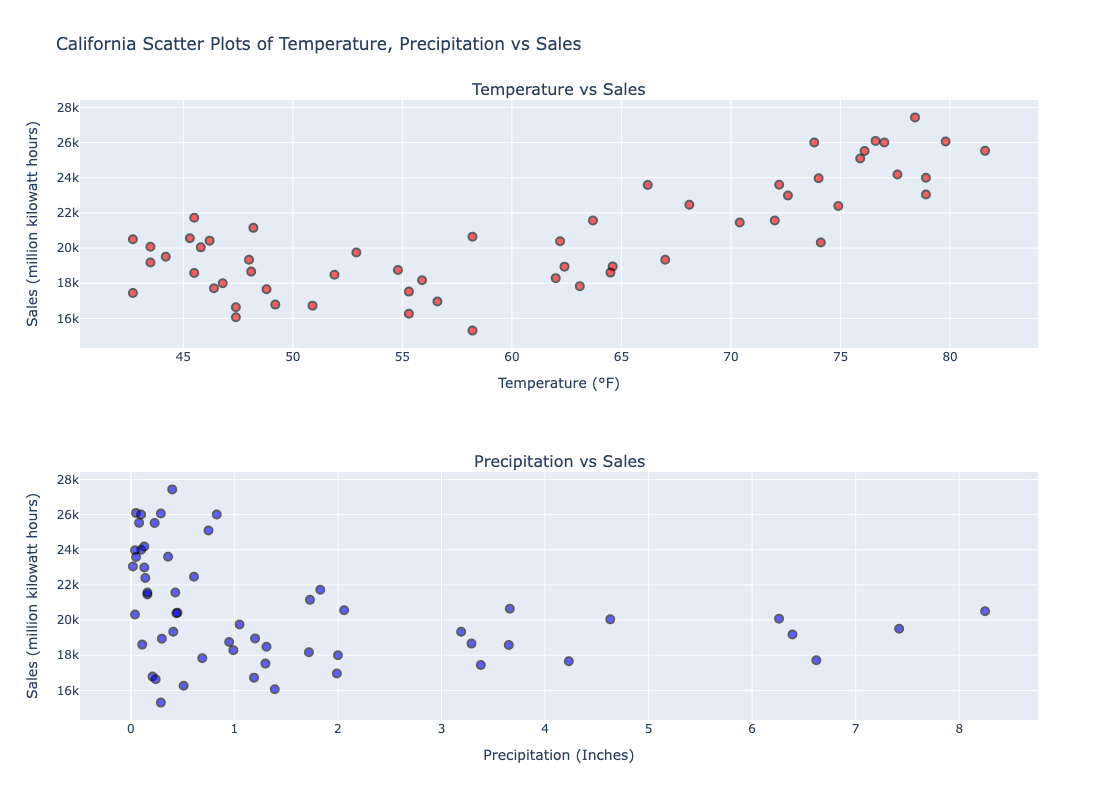

In [321]:
# First scatter plot
fig1 = px.scatter(CA_data, x='temperature', y='sales', 
                  title='California Scatter Plot of Temperature vs Sales',
                  labels={'temperature': 'Temperature', 'sales': 'Sales (million kilowatt hours)'},
                  hover_data=['temperature', 'sales'])
fig1.update_traces(marker=dict(size=8, color='red', opacity=0.6, line=dict(width=2, color='black')))

#Second scatter plot
fig2 = px.scatter(CA_data, x='precipitation', y='sales', 
                  title='California Scatter Plot of Precipitation vs Sales',
                  labels={'precipitation': 'Precipitation', 'sales': 'Sales (million kilowatt hours)'},
                  hover_data=['temperature', 'sales'])
fig2.update_traces(marker=dict(size=8, color='blue', opacity=0.6, line=dict(width=2, color='black')))

# 2 rows one column
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=('Temperature vs Sales', 'Precipitation vs Sales'),
                    vertical_spacing=0.2)

# Add traces from fig1 to the first subplot (row 1, col 1)
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# Add traces from fig2 to the second subplot (row 2, col 1)
for trace in fig2.data:
    fig.add_trace(trace, row=2, col=1)

# Update axis properties (make them wider)
fig.update_layout(
    width=800,  # Make the plot wider
    height=800,  # Adjust the height as per your preference
    title_text='California Scatter Plots of Temperature, Precipitation vs Sales',
    showlegend=False,
    xaxis=dict(title='Temperature (°F)', showgrid=True),
    xaxis2=dict(title='Precipitation (Inches)', showgrid=True),
    yaxis=dict(title='Sales (million kilowatt hours)', showgrid=True),
    yaxis2=dict(title='Sales (million kilowatt hours)', showgrid=True)
)

# Show the plot
fig.write_html('CA_Scatter.html')

fig.show()


In [322]:
FileLink('CA_Scatter.html')

/Users/NoahGlosson/Desktop/STA 141B Material/CA_Scatter.html

New York Data

In [298]:
#All Data
ny_url = "https://api.eia.gov/v2/electricity/retail-sales/data/"

#My personal API Key
api_key = 'hpPWfbFW0MjGinc5M9CHCX64ks6ZXh2DWlmgFQIm'

#Headers
headers = {
    "X-API-Key": api_key
}

#Proper Parameters
params = {
    "frequency": "monthly",
    "data[0]": "sales",
    "facets[sectorid][]": "ALL",
    "facets[stateid][]": "NY",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

#Getting our API Through JSON
response = requests.get(ny_url, headers=headers, params=params)
data = response.json()

#Extracting what we want
month_list = [entry['period'] for entry in data['response']['data']]
month_data = month_list[::-1]
sales_list=[float(entry['sales']) for entry in data['response']['data']]
sales_data=sales_list[::-1]


# Assuming month_data and sales_data are already defined
df = pd.DataFrame({
    'date': pd.to_datetime(month_data, format='%Y-%m'),
    'sales': sales_data
})

# Filter the data to include only from 2020 to 2024
new_york_filtered = df[(df['date'] >= '2020-01-01') & (df['date'] <= '2024-11-01')]



In [299]:
driver = webdriver.Chrome()
#Big url
base_url="https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/30/tavg/1/0/2020-2024"
params = {
    "base_prd": "true",          
    "begbaseyear": "1901",       
    "endbaseyear": "2000"        
}

# Construct URL with parameters
ny_url = f"{base_url}?base_prd={params['base_prd']}&begbaseyear={params['begbaseyear']}&endbaseyear={params['endbaseyear']}"
# Define parameters
driver.get(ny_url)
time.sleep(5) 
soup = BeautifulSoup(driver.page_source, 'lxml')
table = soup.find('table')

#Dictionary to store results
temp_dict = {}

#If we discovered a table
if table:
    rows = table.find_all('tr')
    for row in rows:
        #Extract Rows
        cols = row.find_all('td')
        # If there are columns in the row (skip the header row)
        if len(cols) > 0:
            #Cleaning up our text
            cols = [col.text.strip() for col in cols]
            time_period = cols[0]
            temp_str = cols[1]
            #Removing Farenheit symbol and turning the temperatures into floats
            temp_float = float(temp_str.replace('°F', '').strip()) 
            
            #Creating a dictionary
            temp_dict[time_period] = temp_float

ny_temp_dictionary= dict(reversed(list(temp_dict.items()))) #Reversing the order
driver.quit()

In [300]:
ny_temperatures=list(ny_temp_dictionary.values())
len(ny_temperatures)
#We want to get rid of final two months
temp_values=ny_temperatures[:-2]
new_york_filtered['temperature']=temp_values

/var/folders/ms/1jfxwvmn1r99486_p5c6snv00000gq/T/ipykernel_226/2904567212.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [301]:
driver = webdriver.Chrome()
# Define parameters
base_url="https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/30/pcp/1/0/2020-2024"
params = {
    "base_prd": "true",          
    "begbaseyear": "1901",       
    "endbaseyear": "2000"        
}

# Construct URL with parameters
ny_url = f"{base_url}?base_prd={params['base_prd']}&begbaseyear={params['begbaseyear']}&endbaseyear={params['endbaseyear']}"
driver.get(ny_url)
time.sleep(5) 
soup = BeautifulSoup(driver.page_source, 'lxml')
table = soup.find('table')

#Dictionary to store results
pcp_dict = {}

#If we discovered a table
if table:
    rows = table.find_all('tr')
    for row in rows:
        #Extract Rows
        cols = row.find_all('td')
        # If there are columns in the row (skip the header row)
        if len(cols) > 0:
            #Cleaning up our text
            cols = [col.text.strip() for col in cols]
            time_period = cols[0]
            pcp_str = cols[1]
            #Removing Farenheit symbol and making temperatures floats
            pcp_float = float(pcp_str.replace('"', '').strip()) 
            
            #Creating a dictionary
            pcp_dict[time_period] = pcp_float

pcp_dictionary= dict(reversed(list(pcp_dict.items()))) #Reversing the order
driver.quit()


In [302]:
prec_values=list(pcp_dictionary.values())
prec_values=prec_values[:-2]
# Create a scatter plot instead of a line plot
new_york_filtered['precipitation']=prec_values
ny_data=new_york_filtered
ny_data = ny_data.reset_index(drop=True)
ny_data['date'] = pd.to_datetime(ny_data['date'])
# Format the date as 'Month Year
ny_data['month'] = ny_data['date'].dt.strftime('%b. %Y')
#Creating our new Data Frame
ny_data = ny_data[['month'] + [col for col in ny_data.columns if col != 'month' and col != 'date']]
ny_data #Data Frame

/var/folders/ms/1jfxwvmn1r99486_p5c6snv00000gq/T/ipykernel_226/3441038588.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,month,sales,temperature,precipitation
0,Jan. 2020,12200.52008,27.7,2.78
1,Feb. 2020,11497.06322,26.6,3.03
2,Mar. 2020,11162.18297,37.2,2.89
3,Apr. 2020,10322.36486,41.1,3.15
4,May. 2020,9729.97032,54.2,3.03
5,Jun. 2020,11464.54553,65.2,2.38
6,Jul. 2020,14462.22528,72.9,4.10
7,Aug. 2020,14164.86484,68.6,4.61
8,Sep. 2020,12416.35791,59.6,2.58
9,Oct. 2020,10780.31188,49.0,3.95


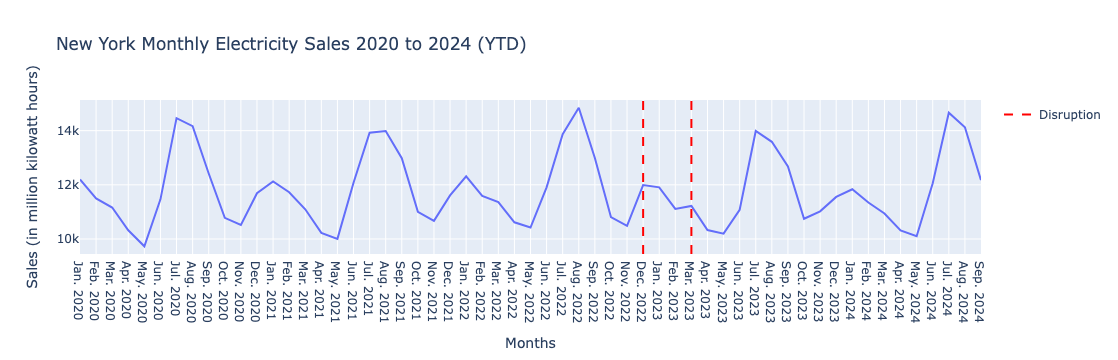

In [303]:
# Create an interactive line plot using Plotly Express
fig = px.line(ny_data, x='month', y='sales', 
              title='New York Monthly Electricity Sales 2020 to 2024 (YTD)', 
              labels={'month': 'Month', 'sales': 'Sales (in million kilowatt hours)'})

# Update our x axis
fig.update_layout(
    xaxis_tickformat='%b. %Y',  #Change format
    xaxis_title='Months',
    yaxis_title='Sales (in million kilowatt hours)'
)
line_month = ny_data['month'].iloc[35] 
fig.add_vline(x=line_month, 
              line=dict(color='red', dash='dash'))
line_month2 = ny_data['month'].iloc[38] 
fig.add_vline(x=line_month2, 
              line=dict(color='red', dash='dash'))


fig.add_trace(
    go.Scatter(x=[None], y=[None], mode='lines', 
               line=dict(color='red', dash='dash'),
               name='Disruption', showlegend=True)
)

# Show the plot
fig.show()




In [ ]:
FileLink('NY_Time.html')

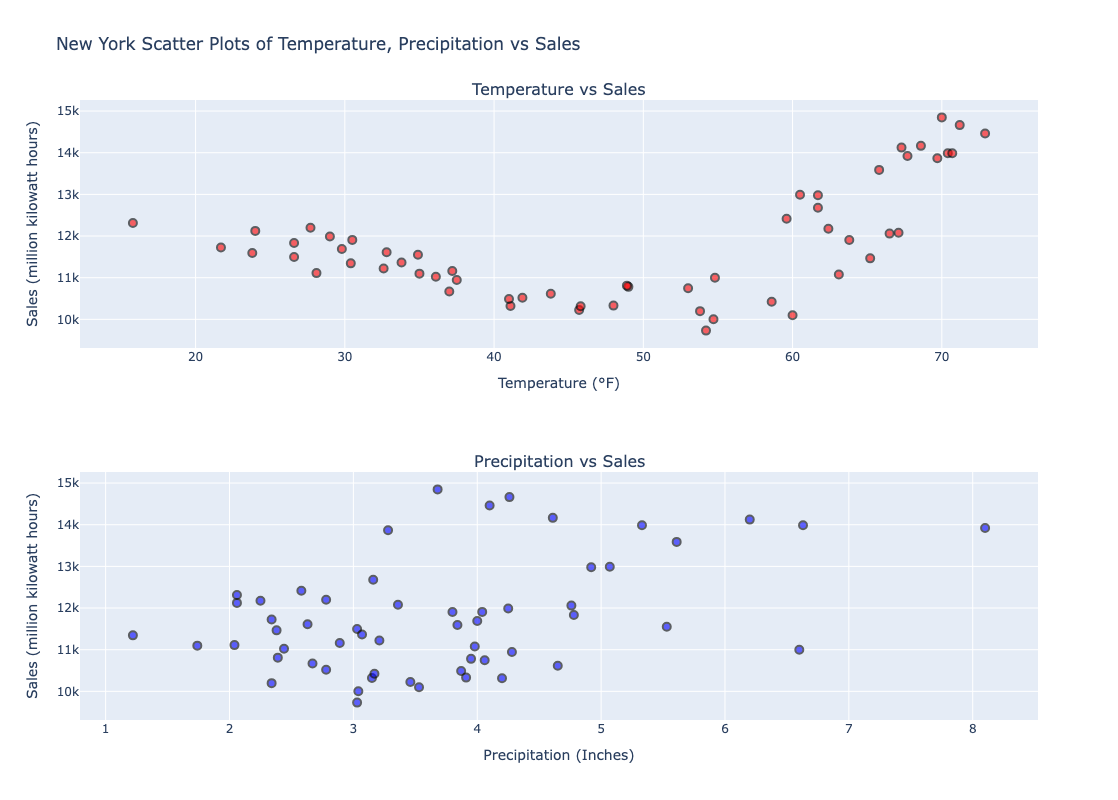

In [313]:
# First scatter plot
fig1 = px.scatter(ny_data, x='temperature', y='sales', 
                  title='New York Scatter Plot of Temperature vs Sales',
                  labels={'temperature': 'Temperature', 'sales': 'Sales (million kilowatt hours)'},
                  hover_data=['temperature', 'sales'])
fig1.update_traces(marker=dict(size=8, color='red', opacity=0.6, line=dict(width=2, color='black')))

#Second scatter plot
fig2 = px.scatter(ny_data, x='precipitation', y='sales', 
                  title='New York Scatter Plot of Precipitation vs Sales',
                  labels={'precipitation': 'Precipitation', 'sales': 'Sales (million kilowatt hours)'},
                  hover_data=['temperature', 'sales'])
fig2.update_traces(marker=dict(size=8, color='blue', opacity=0.6, line=dict(width=2, color='black')))

# 2 rows one column
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=('Temperature vs Sales', 'Precipitation vs Sales'),
                    vertical_spacing=0.2)

# Add traces from fig1 to the first subplot (row 1, col 1)
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# Add traces from fig2 to the second subplot (row 2, col 1)
for trace in fig2.data:
    fig.add_trace(trace, row=2, col=1)

# Update axis properties (make them wider)
fig.update_layout(
    width=800,  # Make the plot wider
    height=800,  # Adjust the height as per your preference
    title_text='New York Scatter Plots of Temperature, Precipitation vs Sales',
    showlegend=False,
    xaxis=dict(title='Temperature (°F)', showgrid=True),
    xaxis2=dict(title='Precipitation (Inches)', showgrid=True),
    yaxis=dict(title='Sales (million kilowatt hours)', showgrid=True),
    yaxis2=dict(title='Sales (million kilowatt hours)', showgrid=True)
)

# Show the plot
fig.write_html('ny_scatter_plots.html')

fig.show()

In [315]:

FileLink('ny_scatter_plots.html')

/Users/NoahGlosson/Desktop/STA 141B Material/ny_scatter_plots.html